# **Project SEE-DR: Diabetic Retinopathy Segmentation Data Pipeline**

**Run this notebook from top to bottom and you will receive a folder containing 3 datasets (512x512, 768x768, 1024x1024). Make sure you have the correct dataset files structure!** 

Data is loaded, augmented, and saved into .pt files for training.

In [9]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import albumentations as A
from albumentations import ToTensorV2
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
import random
print("")

## **1. Create DataFrames**
Extracts the image and mask paths from the folder. All data is extracted at once into one dataframe. Train-test 75/25 split is applied after we get the full dataframe.

**Important!: Files must have this exact structure:**  
```
cmac-segmentation (root)/
├── DDR-SEGMENTATION/
│   ├── train/
│   │   ├── image/
│   │   └── label/
│   │       ├── EX/
│   │       ├── HE/
│   │       ├── MA/
│   │       └── SE/
│   ├── test/
│   │   ├── image/
│   │   └── label/
│   │       ├── EX/
│   │       ├── HE/
│   │       ├── MA/
│   │       └── SE/
│   └── valid/
│       ├── image/
│       └── label/
│           ├── EX/
│           ├── HE/
│           ├── MA/
│           └── SE/
└── IDRID/
    ├── Original_Images/
    │   ├── test/
    │   └── train/
    └── Segmentation_Groundtruths/
        ├── test/
        │   ├── 1. Microaneurysms/
        │   ├── 2. Haemorrhages/
        │   ├── 3. Hard Exudates/
        │   ├── 4. Soft Exudates/
        │   └── 5. Optic Disk/
        └── train/
            ├── 1. Microaneurysms/
            ├── 2. Haemorrhages/
            ├── 3. Hard Exudates/
            ├── 4. Soft Exudates/
            └── 5. Optic Disk/
```

In [10]:
def build_dataframe(ddr_root: str, idrid_root: str):
    rows = []
    for root, dirs, files in os.walk(ddr_root):
        for f in files:
            if f.lower().endswith('.jpg') and os.path.basename(root) == "image":
                img_path = os.path.join(root, f)
                base = os.path.splitext(f)[0]
                label_root = root.replace("image", "label")

                ex = os.path.join(label_root, "EX", base + ".tif")
                he = os.path.join(label_root, "HE", base + ".tif")
                ma = os.path.join(label_root, "MA", base + ".tif")
                se = os.path.join(label_root, "SE", base + ".tif")
                od = os.path.join(label_root, "OD", base + ".tif")

                rows.append({
                    "dataset": "DDR",
                    "image_path": img_path,
                    "ex_path": ex if os.path.exists(ex) else None,
                    "he_path": he if os.path.exists(he) else None,
                    "ma_path": ma if os.path.exists(ma) else None,
                    "se_path": se if os.path.exists(se) else None,
                    "od_path": od if os.path.exists(od) else None
                })
    for split in ["train", "test"]:
        img_dir = os.path.join(idrid_root, "Original_Images", split)
        if not os.path.exists(img_dir):
            continue

        for f in os.listdir(img_dir):
            if f.lower().endswith(('.jpg', '.png', '.jpeg', '.tif')):
                img_path = os.path.join(img_dir, f)
                base = os.path.splitext(f)[0]

                mask_base = os.path.join(idrid_root, "Segmentation_Groundtruths", split)

                ma = os.path.join(mask_base, "1. Microaneurysms", base + "_MA.tif")
                he = os.path.join(mask_base, "2. Haemorrhages", base + "_HE.tif")
                ex = os.path.join(mask_base, "3. Hard Exudates", base + "_EX.tif")
                se = os.path.join(mask_base, "4. Soft Exudates", base + "_SE.tif")
                od = os.path.join(mask_base, "5. Optic Disc", base + "_OD.tif")

                rows.append({
                    "dataset": "IDRID",
                    "image_path": img_path,
                    "ma_path": ma if os.path.exists(ma) else None,
                    "he_path": he if os.path.exists(he) else None,
                    "ex_path": ex if os.path.exists(ex) else None,
                    "se_path": se if os.path.exists(se) else None,
                    "od_path": od if os.path.exists(od) else None
                })

    df = pd.DataFrame(rows)
    return df

df = build_dataframe('../DDR-SEGMENTATION', '../IDRID')


In [11]:
df.isna().sum()

dataset        0
image_path     0
ex_path        0
he_path        1
ma_path        0
se_path       41
od_path        0
dtype: int64

In [12]:
df.shape

(838, 7)

In [13]:
df.sample(10)

,dataset,image_path,ex_path,he_path,ma_path,se_path,od_path
748,DDR,../DDR-SEGMENTATION/train/image/007-5617-300.jpg,../DDR-SEGMENTATION/train/label/EX/007-5617-30...,../DDR-SEGMENTATION/train/label/HE/007-5617-30...,../DDR-SEGMENTATION/train/label/MA/007-5617-30...,../DDR-SEGMENTATION/train/label/SE/007-5617-30...,../DDR-SEGMENTATION/train/label/OD/007-5617-30...
641,DDR,../DDR-SEGMENTATION/train/image/007-4687-200.jpg,../DDR-SEGMENTATION/train/label/EX/007-4687-20...,../DDR-SEGMENTATION/train/label/HE/007-4687-20...,../DDR-SEGMENTATION/train/label/MA/007-4687-20...,../DDR-SEGMENTATION/train/label/SE/007-4687-20...,../DDR-SEGMENTATION/train/label/OD/007-4687-20...
362,DDR,../DDR-SEGMENTATION/test/image/201705051637588...,../DDR-SEGMENTATION/test/label/EX/201705051637...,../DDR-SEGMENTATION/test/label/HE/201705051637...,../DDR-SEGMENTATION/test/label/MA/201705051637...,../DDR-SEGMENTATION/test/label/SE/201705051637...,../DDR-SEGMENTATION/test/label/OD/201705051637...
532,DDR,../DDR-SEGMENTATION/train/image/007-4285-200.jpg,../DDR-SEGMENTATION/train/label/EX/007-4285-20...,../DDR-SEGMENTATION/train/label/HE/007-4285-20...,../DDR-SEGMENTATION/train/label/MA/007-4285-20...,../DDR-SEGMENTATION/train/label/SE/007-4285-20...,../DDR-SEGMENTATION/train/label/OD/007-4285-20...
141,DDR,../DDR-SEGMENTATION/valid/image/20170502000225...,../DDR-SEGMENTATION/valid/label/EX/20170502000...,../DDR-SEGMENTATION/valid/label/HE/20170502000...,../DDR-SEGMENTATION/valid/label/MA/20170502000...,../DDR-SEGMENTATION/valid/label/SE/20170502000...,../DDR-SEGMENTATION/valid/label/OD/20170502000...
80,DDR,../DDR-SEGMENTATION/valid/image/007-5863-300.jpg,../DDR-SEGMENTATION/valid/label/EX/007-5863-30...,../DDR-SEGMENTATION/valid/label/HE/007-5863-30...,../DDR-SEGMENTATION/valid/label/MA/007-5863-30...,../DDR-SEGMENTATION/valid/label/SE/007-5863-30...,../DDR-SEGMENTATION/valid/label/OD/007-5863-30...
225,DDR,../DDR-SEGMENTATION/test/image/007-3748-200.jpg,../DDR-SEGMENTATION/test/label/EX/007-3748-200...,../DDR-SEGMENTATION/test/label/HE/007-3748-200...,../DDR-SEGMENTATION/test/label/MA/007-3748-200...,../DDR-SEGMENTATION/test/label/SE/007-3748-200...,../DDR-SEGMENTATION/test/label/OD/007-3748-200...
159,DDR,../DDR-SEGMENTATION/test/image/007-4287-200.jpg,../DDR-SEGMENTATION/test/label/EX/007-4287-200...,../DDR-SEGMENTATION/test/label/HE/007-4287-200...,../DDR-SEGMENTATION/test/label/MA/007-4287-200...,../DDR-SEGMENTATION/test/label/SE/007-4287-200...,../DDR-SEGMENTATION/test/label/OD/007-4287-200...
27,DDR,../DDR-SEGMENTATION/valid/image/007-5843-300.jpg,../DDR-SEGMENTATION/valid/label/EX/007-5843-30...,../DDR-SEGMENTATION/valid/label/HE/007-5843-30...,../DDR-SEGMENTATION/valid/label/MA/007-5843-30...,../DDR-SEGMENTATION/valid/label/SE/007-5843-30...,../DDR-SEGMENTATION/valid/label/OD/007-5843-30...
88,DDR,../DDR-SEGMENTATION/valid/image/20170503090730...,../DDR-SEGMENTATION/valid/label/EX/20170503090...,../DDR-SEGMENTATION/valid/label/HE/20170503090...,../DDR-SEGMENTATION/valid/label/MA/20170503090...,../DDR-SEGMENTATION/valid/label/SE/20170503090...,../DDR-SEGMENTATION/valid/label/OD/20170503090...


In [14]:
# Split the dataframe for testing, validation and training
train_df, temp_df = train_test_split(
    df,
    test_size = 0.30,
    random_state = 42,
    shuffle = True
)

val_df, test_df = train_test_split(
    temp_df,
    test_size = 1/3,
    random_state = 42,
    shuffle = True
)

train_df = train_df.reset_index(drop = True)
val_df   = val_df.reset_index(drop = True)
test_df  = test_df.reset_index(drop = True)

In [15]:
from pathlib import Path

DATA_DIR = Path("..") / "data_csv"
DATA_DIR.mkdir(exist_ok = True)

train_df.to_pickle(DATA_DIR / "train_df.pkl")
val_df.to_pickle(DATA_DIR / "val_df.pkl")
test_df.to_pickle(DATA_DIR / "test_df.pkl")

In [16]:
len(train_df), len(val_df), len(test_df)

(586, 168, 84)

## **2. Dataset and Augmentation Definitions**

In [17]:
def center_crop_largest_square(image, **kwargs):
    h, w = image.shape[:2]
    min_dim = min(h, w)
    top = (h - min_dim) // 2
    left = (w - min_dim) // 2
    return image[top : top + min_dim, left:left + min_dim]

In [18]:
class FundusSegmentationDataset(Dataset):
    """
    Helps produces the Fundus Dataset. There are 5 transform_type's. 
    We apply this class 5 times for each transform.

    Transforms:
    All transforms are applied to the masks and the image
    All transforms starting by cropping the largest square possible from the center of the image
    All transforms end by resizing to (self.dimensions, self.dimensions)
        t1 and test: Only Resize
        t2: Horizontal Flip
        t3: + or - 20% max zoom
        t4: Brightness and Contrast, Random Gamma
        t5: + or - 20 degree max rotation
        t6: Color Adjustments
        t7: Elastic Transform

    Default dimensions are 1024x1024. 
    Each mask is its own channel so the returned shapes are:
    image: (3, 1024, 1024)
    masks: (5, 1024, 1024)
    """
    def __init__(self, df: pd.DataFrame, dimensions: int = 1024, transform_type = None):
        self.df = df.reset_index(drop = True)
        self.dimensions = dimensions
        self.transform_type = transform_type
        self.transforms = self._build_transforms(transform_type)

    def _build_transforms(self, ttype):
        """ttype is any of (t1, t2, t3, t4, t5, t6, t7, test)"""
        if ttype is None:
            return None
        if ttype == 't1' or ttype == 'test':
            return A.Compose(
                [
                    A.Lambda(
                        image = center_crop_largest_square,
                        mask = center_crop_largest_square
                    ),
                    A.Resize(self.dimensions, self.dimensions)
            ],
                additional_targets = {
                        "mask1": "mask",
                        "mask2": "mask",
                        "mask3": "mask",
                        "mask4": "mask",
                        "mask5": "mask",
                },
                is_check_shapes = False
                )
        if ttype == "t2":
            return A.Compose(
                [
                    A.Lambda(
                        image = center_crop_largest_square,
                        mask = center_crop_largest_square
                    ),
                    A.HorizontalFlip(p = 1.0),
                    A.Resize(self.dimensions, self.dimensions)
                ], 
                additional_targets = {
                    "mask1": "mask",
                    "mask2": "mask",
                    "mask3": "mask",
                    "mask4": "mask",
                    "mask5": "mask",
                },
                is_check_shapes = False
            )
        if ttype == "t3":
            return A.Compose(
                [
                    A.Lambda(
                        image = center_crop_largest_square,
                        mask = center_crop_largest_square
                    ),
                    A.Affine(
                        scale = (0.80, 1.20),
                        translate_px = 0,
                        rotate = 0,
                        border_mode = cv2.BORDER_CONSTANT,
                        fill = 0,
                        fill_mask = 0,
                        p = 1.0
                    ),
                    A.Resize(self.dimensions, self.dimensions)
                ],
                additional_targets = {
                    "mask1": "mask",
                    "mask2": "mask",
                    "mask3": "mask",
                    "mask4": "mask",
                    "mask5": "mask",
                },
                is_check_shapes = False
            )
        if ttype == "t4":
            return A.Compose(
                [
                    A.Lambda(
                        image = center_crop_largest_square,
                        mask = center_crop_largest_square
                    ),
                    A.RandomBrightnessContrast(
                        brightness_limit = 0.2,
                        contrast_limit = 0.2,
                        p = 1.0
                    ),
                    A.RandomGamma(
                        gamma_limit = (80, 120),
                        p = 0.5
                    ),
                    A.Resize(self.dimensions, self.dimensions)
                ],
                additional_targets = {
                    "mask1": "mask",
                    "mask2": "mask",
                    "mask3": "mask",
                    "mask4": "mask",
                    "mask5": "mask",
                },
                is_check_shapes = False
            )
        if ttype == "t5":
            return A.Compose(
                [
                    A.Lambda(
                        image = center_crop_largest_square,
                        mask = center_crop_largest_square
                    ),
                    A.Rotate(
                        limit = 20,
                        border_mode = cv2.BORDER_CONSTANT,
                        fill = 0,
                        fill_mask = 0,
                        p = 1.0
                    ),
                    A.Resize(self.dimensions, self.dimensions)
                ],
                additional_targets = {
                    "mask1": "mask",
                    "mask2": "mask",
                    "mask3": "mask",
                    "mask4": "mask",
                    "mask5": "mask",
                },
                is_check_shapes = False
            )
        if ttype == "t6":
            return A.Compose(
                [
                    A.Lambda(
                        image = center_crop_largest_square,
                        mask = center_crop_largest_square
                    ),
                    A.HueSaturationValue(
                        hue_shift_limit = 10,
                        sat_shift_limit = 20,
                        val_shift_limit = 10,
                        p = 0.8
                    ),
                    A.Resize(self.dimensions, self.dimensions)
                ],
                additional_targets = {
                    "mask1": "mask",
                    "mask2": "mask",
                    "mask3": "mask",
                    "mask4": "mask",
                    "mask5": "mask",
                },
                is_check_shapes = False
            )
        if ttype == "t7":
            return A.Compose(
                [
                    A.Lambda(
                        image = center_crop_largest_square,
                        mask = center_crop_largest_square
                    ),
                    A.ElasticTransform(
                        alpha = 100,
                        sigma = 10,
                        border_mode = cv2.BORDER_CONSTANT,
                        p = 1.0
                    ),
                    A.Resize(self.dimensions, self.dimensions)
                ],
                additional_targets = {
                    "mask1": "mask",
                    "mask2": "mask",
                    "mask3": "mask",
                    "mask4": "mask",
                    "mask5": "mask",
                },
                is_check_shapes = False
            )

    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        row = self.df.loc[index]
        image = cv2.imread(row.image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask_paths = [row.ex_path, row.he_path, row.ma_path, row.se_path, row.od_path]

        masks = []
        for path in mask_paths:
            if path is None:
                height, width = image.shape[:2]
                mask = np.zeros((height, width), dtype = np.uint8)
            else:
                mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                mask = (mask > 0).astype(np.uint8)
            masks.append(mask)

        if self.transforms:
            data = self.transforms(
                image = image,
                mask1 = masks[0],
                mask2 = masks[1],
                mask3 = masks[2],
                mask4 = masks[3],
                mask5 = masks[4]
            )

            image = data["image"]
            masks = [
                data["mask1"],
                data["mask2"],
                data["mask3"],
                data["mask4"],
                data["mask5"]
            ]

        image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.
        masks = torch.stack([torch.from_numpy(m) for m in masks]).float()

        return image, masks

## **3. DataLoaders**

In [19]:
def build_fundus_train_dataset(df, dimensions):
    transform_types = ["t1", "t2", "t3", "t4", "t5", "t6", "t7"]
    datasets = [
        FundusSegmentationDataset(
            df,
            dimensions = dimensions,
            transform_type = t
        )
        for t in transform_types
    ]
    return ConcatDataset(datasets)

def build_fundus_test_dataset(df, dimensions):
    return FundusSegmentationDataset(
        df,
        dimensions = dimensions,
        transform_type = "test"
    )

In [20]:
train_ds_512  = build_fundus_train_dataset(train_df, 512)
train_ds_768  = build_fundus_train_dataset(train_df, 768)
train_ds_1024 = build_fundus_train_dataset(train_df, 1024)

val_ds_512  = build_fundus_test_dataset(val_df, 512)
val_ds_768  = build_fundus_test_dataset(val_df, 768)
val_ds_1024 = build_fundus_test_dataset(val_df, 1024)

test_ds_512  = build_fundus_test_dataset(test_df, 512)
test_ds_768  = build_fundus_test_dataset(test_df, 768)
test_ds_1024 = build_fundus_test_dataset(test_df, 1024)

In [21]:
# Build DataLoaders
def build_loader(dataset, batch_size, shuffle = True):
    return DataLoader(
        dataset,
        batch_size = batch_size,
        shuffle = shuffle,
        num_workers = 0,
        pin_memory = True
    )

# ---- Train loaders ----
train_loader_512  = build_loader(train_ds_512,  batch_size = 16, shuffle = True)
train_loader_768  = build_loader(train_ds_768,  batch_size = 16, shuffle = True)
train_loader_1024 = build_loader(train_ds_1024, batch_size = 16, shuffle = True)

# ---- Validation loaders ----
val_loader_512  = build_loader(val_ds_512,  batch_size = 16, shuffle = False)
val_loader_768  = build_loader(val_ds_768,  batch_size = 16, shuffle = False)
val_loader_1024 = build_loader(val_ds_1024, batch_size = 16, shuffle = False)

# ---- Test loaders ----
test_loader_512  = build_loader(test_ds_512,  batch_size = 16, shuffle = False)
test_loader_768  = build_loader(test_ds_768,  batch_size = 16, shuffle = False)
test_loader_1024 = build_loader(test_ds_1024, batch_size = 16, shuffle = False)

In [22]:
len(train_loader_512), len(train_loader_768), len(train_loader_1024)

(257, 257, 257)

In [23]:
len(val_loader_512), len(val_loader_768), len(val_loader_1024)

(11, 11, 11)

In [24]:
len(test_loader_512), len(test_loader_768), len(test_loader_1024)

(6, 6, 6)

## **4. Visualizations**

In [25]:
# RGB colors for each mask channel
COLOR_MAP = {
    0: (91, 0, 133),            # EX -> orange
    1: (255, 0, 204),           # HE -> pink
    2: (255, 255, 0),           # MA -> yellow
    3: (53, 192, 220),          # SE -> cyan
    4: (37, 183, 76),           # OD -> green
}

CLASS_NAMES = ["EX", "HE", "MA", "SE", "OD"]

In [26]:
def visualize_sample(dataset, index = 0, alpha = 0.8):
    plt.rcParams['font.family'] = 'Serif'
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams['axes.titleweight'] = 'bold'

    img, masks = dataset[index]  # img: (3, H, W), masks: (5, H, W)
    img_np = img.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(figsize = (6, 6))

    # 1. Draw fundus image FIRST (unchanged)
    ax.imshow(img_np)

    # 2. Draw each mask ON TOP with its own alpha
    for i in range(5):
        mask = masks[i].numpy()

        colored_mask = np.zeros((*mask.shape, 4))  # RGBA
        color = np.array(COLOR_MAP[i]) / 255.0

        colored_mask[..., :3] = color
        colored_mask[..., 3] = mask * alpha  # opacity only where mask == 1

        ax.imshow(colored_mask)

    ax.set_title("Image + Mask Overlay", fontsize = 24)
    ax.axis("off")

    # Legend
    legend_elements = [
        plt.Line2D(
            [0], [0],
            marker = 'o',
            color = 'w',
            markerfacecolor = np.array(COLOR_MAP[i]) / 255.0,
            markersize = 20,
            label = CLASS_NAMES[i]
        )
        for i in range(len(CLASS_NAMES))
    ]

    fig.legend(
        handles = legend_elements,
        loc = 'lower center',
        ncol = 5,
        frameon = False,
        fontsize = 16,
        bbox_to_anchor = (0.5, -0.15),
    )

    plt.tight_layout()
    plt.show()


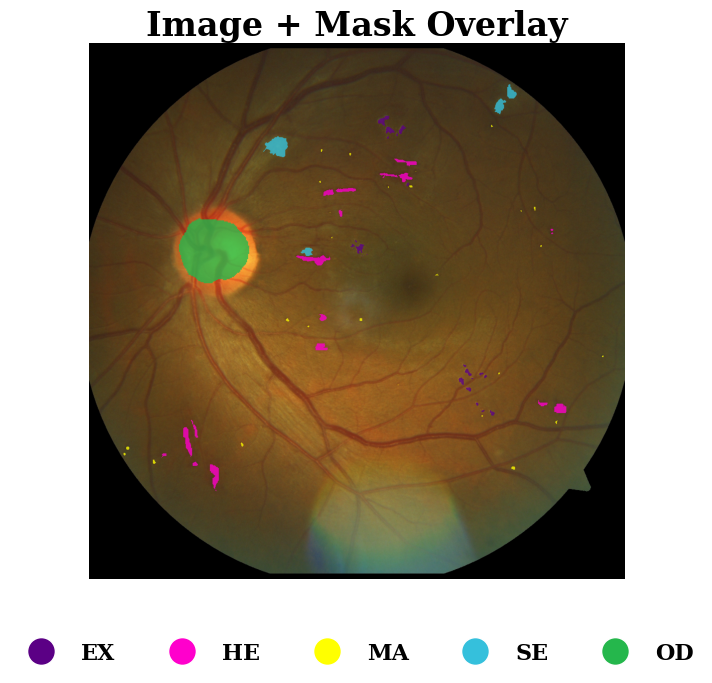

In [ ]:
visualize_sample(train_ds_1024, index = random.randint(0, 100))